In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Notebook Color Scheme:


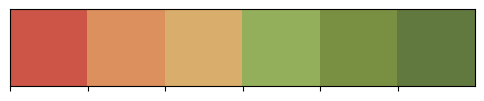

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import wandb
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from tqdm import tqdm
import glob
import cv2

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'AWMadison', '_wandb_kernel': 'avb'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[92m'
    E = '\033[0m'
    
my_colors = ["#CC5547", "#DB905D", "#D9AE6C", "#93AF5C", "#799042", "#61783F"]
print(clr.S+"Notebook Color Scheme:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [3]:
!pip install --upgrade -q wandb

^C
ERROR: Operation cancelled by user


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wb_login")

! wandb login $secret_value_0

**Helper Functions for Weights&Biases**

In [4]:
def save_dataset_artifact(run_name, artifact_name, path):
    '''Saves dataset to W&B Artifactory.
    run_name: name of the experiment
    artifact_name: under what name should the dataset be stored
    path: path to the dataset'''
    
    run = wandb.init(project='AWMadison', 
                     name=run_name, 
                     config=CONFIG)
    artifact = wandb.Artifact(name=artifact_name, 
                              type='dataset')
    artifact.add_file(path)

    wandb.log_artifact(artifact)
    wandb.finish()
    print("Artifact has been saved successfully.")
    
    
def create_wandb_plot(x_data=None, y_data=None, x_name=None, y_name=None, title=None, log=None, plot="line"):
    '''Create and save lineplot/barplot in W&B Environment.
    x_data & y_data: Pandas Series containing x & y data
    x_name & y_name: strings containing axis names
    title: title of the graph
    log: string containing name of log'''
    
    data = [[label, val] for (label, val) in zip(x_data, y_data)]
    table = wandb.Table(data=data, columns = [x_name, y_name])
    
    if plot == "line":
        wandb.log({log : wandb.plot.line(table, x_name, y_name, title=title)})
    elif plot == "bar":
        wandb.log({log : wandb.plot.bar(table, x_name, y_name, title=title)})
    elif plot == "scatter":
        wandb.log({log : wandb.plot.scatter(table, x_name, y_name, title=title)})
        
        
def create_wandb_hist(x_data=None, x_name=None, title=None, log=None):
    '''Create and save histogram in W&B Environment.
    x_data: Pandas Series containing x values
    x_name: strings containing axis name
    title: title of the graph
    log: string containing name of log'''
    
    data = [[x] for x in x_data]
    table = wandb.Table(data=data, columns=[x_name])
    wandb.log({log : wandb.plot.histogram(table, x_name, title=title)})
    

# Log Cover Photo
#run = wandb.init(project='AWMadison', name='CoverPhoto', config=CONFIG)
#cover = plt.imread("/kaggle/input/d/avishab97/uw-madison-gi-tract-image-segmentation/Screenshot 2023-09-20 152508.png")
#wandb.log({"example": wandb.Image(cover)})
#wandb.finish()

**Other Helper Functions**

In [4]:
def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap


def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [5]:
# Mask color: yellow: large bowel, purple: small bowel, red: stomach
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]
labels = ["Large Bowel", "Small Bowel", "Stomach"]

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

**New experiment for analysis**

In [8]:
train = pd.read_csv('/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv')

In [22]:
run = wandb.init(project='AWMadison', name='explore', config=CONFIG)

In [15]:
print('-----train.csv-----')
train = pd.read_csv('/kaggle/input/uw-madison-gi-tract-image-segmentation/train.csv')
print('shape: ', train.shape)
print('Unique Case IDs: ', train['id'].nunique())
print('Missing Values are present in column: ', train.isna().sum().index[-1])
print('Total missing rows: ', train.isna().sum().values[-1])
print('Train Data Sample:')
train.sample(5,random_state=5)

-----train.csv-----
shape:  (115488, 3)
Unique Case IDs:  38496
Missing Values are present in column:  segmentation
Total missing rows:  81575
Train Data Sample:


id        class  \
18740     case91_day0_slice_0119      stomach   
30379    case117_day0_slice_0031  small_bowel   
51173   case101_day32_slice_0098      stomach   
86059    case36_day14_slice_0063  small_bowel   
106814   case107_day0_slice_0133      stomach   

                                             segmentation  
18740                                                 NaN  
30379                                                 NaN  
51173                                                 NaN  
86059   25970 12 26234 16 26493 24 26757 27 27021 29 2...  
106814                                                NaN

Mention everything above in words

In [23]:
wandb.log({
    "train_length":train.shape[0],
    "train_cols":train.shape[1],
    "segmentation_no":len(train[train['segmentation'].isna() == False]),
    "segmentation_percentage":round((len(train[train["segmentation"].isna()==False])/train.shape[0])*100, 1)
})

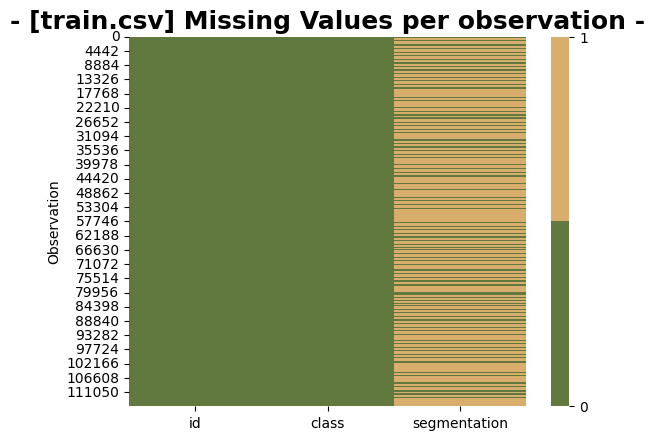

In [18]:
cbar_kws = { 
    "ticks": [0, 1],
}

sns.heatmap(train.isna(), cmap=[my_colors[5], my_colors[2]], cbar_kws=cbar_kws)

plt.title("- [train.csv] Missing Values per observation -", size=18, weight="bold")
plt.xlabel("")
plt.ylabel("Observation")
plt.show();

In [20]:
print('hello world')

hello world


**New columns from image name (Format: slice_ImageHeight_ImageWidth_PixelHeight_PixelWidth.png)**

In [8]:
def get_image_name_features(base_path, df):
    df['case'] = df['id'].apply(lambda x: x.split('_')[0])
    df['day'] = df['id'].apply(lambda x: x.split('_')[1])
    df['slice_no'] = df['id'].apply(lambda x: x.split('_')[-1])
    df['path'] = 0
    n = len(df)
    for k in tqdm(range(n)):
        data = df.iloc[k, :]
        if pd.isnull(df.iloc[k, 2]) == False:
            case = data.case
            day = data.day
            slice_no = data.slice_no
            # Change value to the correct one
            df.loc[k, "path"] = glob.glob(f"{base_path}/{case}/{case}_{day}/scans/slice_{slice_no}*")[0]
            
    return df

In [9]:
base_path = "/kaggle/input/uw-madison-gi-tract-image-segmentation/train"

train = get_image_name_features(base_path, df=train)

print("train.csv now:")
train.head(3)

100%|██████████| 115488/115488 [00:48<00:00, 2391.28it/s]

train.csv now:


id        class segmentation     case    day  \
0  case123_day20_slice_0001  large_bowel          NaN  case123  day20   
1  case123_day20_slice_0001  small_bowel          NaN  case123  day20   
2  case123_day20_slice_0001      stomach          NaN  case123  day20   

  slice_no path  
0     0001    0  
1     0001    0  
2     0001    0

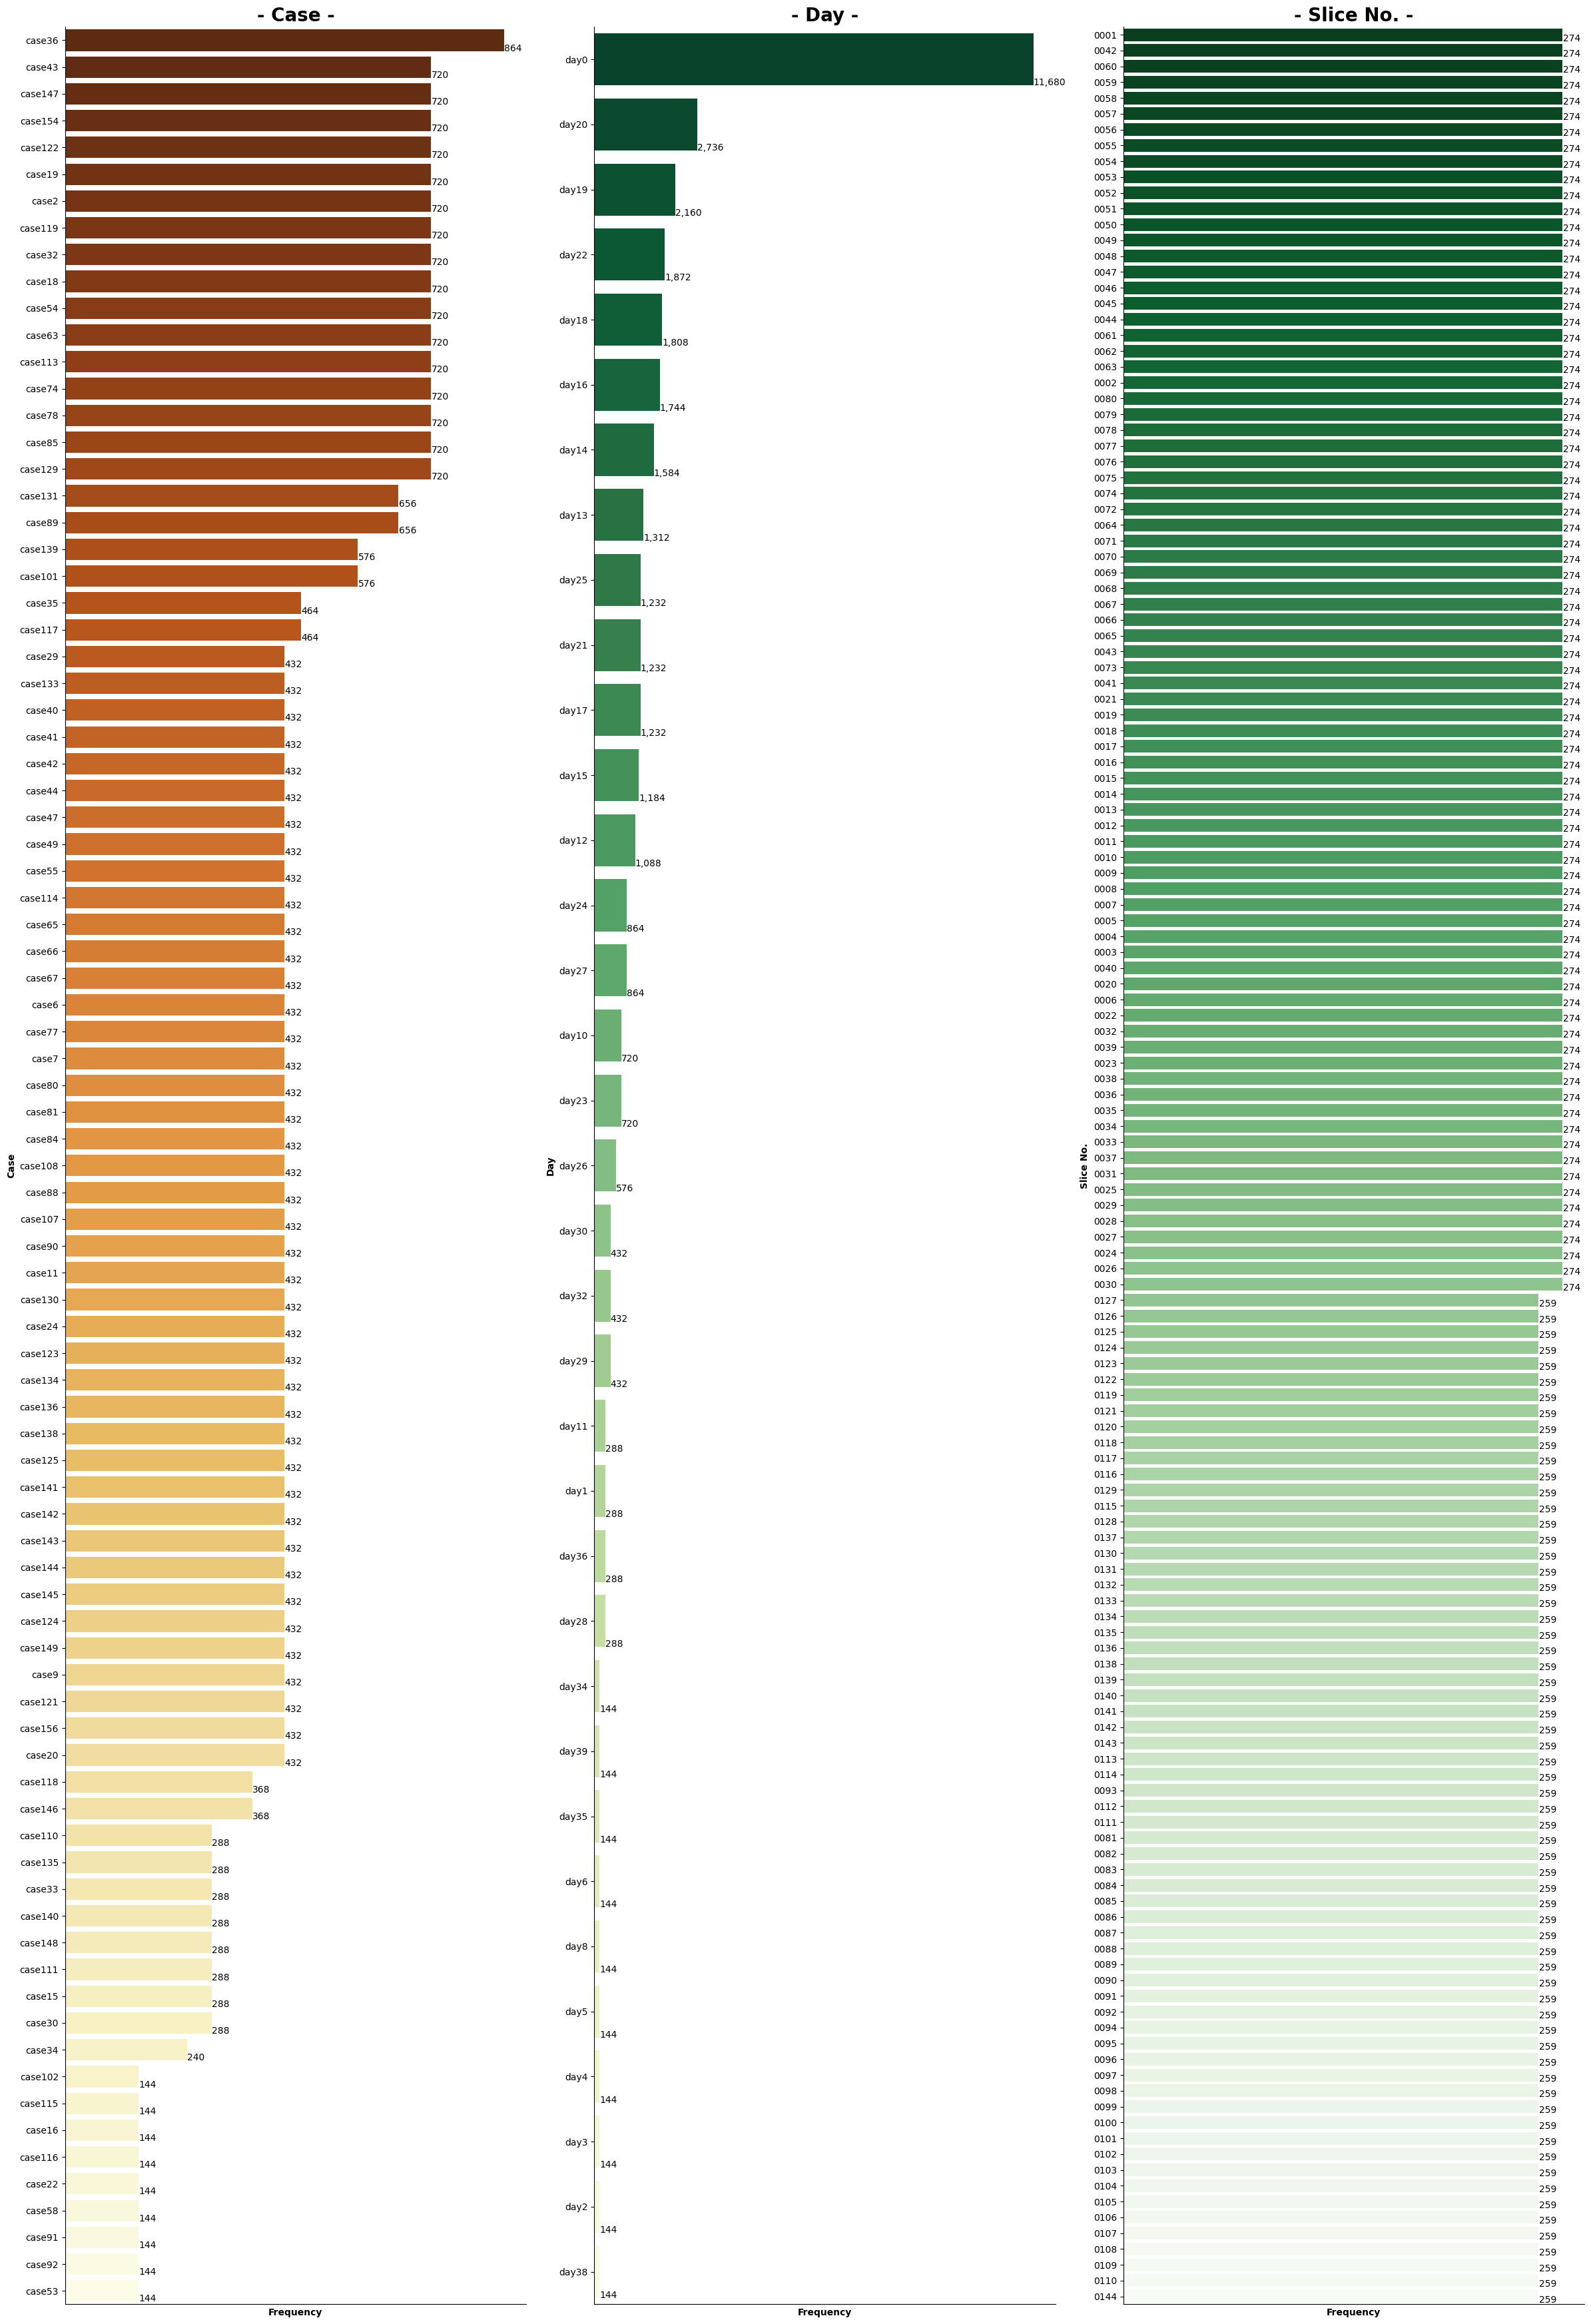

In [41]:
data = train.groupby('id')[['case','day','slice_no']].first().reset_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 35))
titles = ["Case", "Day", "Slice No."]

sns.barplot(x=data['case'].value_counts(), y=data['case'].value_counts().index, ax=ax1, palette="YlOrBr_r")
sns.barplot(x=data['day'].value_counts(), y=data['day'].value_counts().index, ax=ax2, palette="YlGn_r")
sns.barplot(x=data['slice_no'].value_counts(), y=data['slice_no'].value_counts().index, ax=ax3, palette="Greens_r")

for ax, t in zip([ax1, ax2, ax3], titles):
    show_values_on_bars(ax, h_v="h", space=0.4)
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_xlabel("Frequency", weight="bold")
    ax.set_ylabel(f"{t}", weight="bold")
    ax.get_xaxis().set_ticks([]);
    
sns.despine()
fig.tight_layout();

**Image/Pixel Width and Height**

In [10]:
train[train['path'] != 0]['path']

194       /kaggle/input/uw-madison-gi-tract-image-segmen...
197       /kaggle/input/uw-madison-gi-tract-image-segmen...
200       /kaggle/input/uw-madison-gi-tract-image-segmen...
203       /kaggle/input/uw-madison-gi-tract-image-segmen...
206       /kaggle/input/uw-madison-gi-tract-image-segmen...
                                ...                        
115459    /kaggle/input/uw-madison-gi-tract-image-segmen...
115461    /kaggle/input/uw-madison-gi-tract-image-segmen...
115462    /kaggle/input/uw-madison-gi-tract-image-segmen...
115464    /kaggle/input/uw-madison-gi-tract-image-segmen...
115465    /kaggle/input/uw-madison-gi-tract-image-segmen...
Name: path, Length: 33913, dtype: object

In [13]:
s = train.iloc[194,6].split('_')

In [15]:
height_split = s[6].split('.')
height = '.'.join(height_split[:2])
print(height)

1.50


In [11]:
def get_image_size(x, flag):
    if x != 0:
        split = x.split('_')
        width = split[3]
        height = split[4]
        
        if flag == 'width':
            return int(width)
        elif flag == 'height':
            return int(height)
    return 0

def get_pixel_size(x, flag):
    if x != 0:
        split = x.split('_')
        width = split[5]
        
        height_split = split[6].split('.')
        height = '.'.join(height_split[:2])
        
        if flag == 'width':
            return float(width)
        elif flag == 'height':
            return float(height)
    return 0 

In [12]:
train["image_width"] = train["path"].apply(lambda x: get_image_size(x, "width"))
train["image_height"] = train["path"].apply(lambda x: get_image_size(x, "height"))

train["pixel_width"] = train["path"].apply(lambda x: get_pixel_size(x, "width"))
train["pixel_height"] = train["path"].apply(lambda x: get_pixel_size(x, "height"))

print("train.csv now:")
train.head(3)

train.csv now:


id        class segmentation     case    day  \
0  case123_day20_slice_0001  large_bowel          NaN  case123  day20   
1  case123_day20_slice_0001  small_bowel          NaN  case123  day20   
2  case123_day20_slice_0001      stomach          NaN  case123  day20   

  slice_no path  image_width  image_height  pixel_width  pixel_height  
0     0001    0            0             0          0.0           0.0  
1     0001    0            0             0          0.0           0.0  
2     0001    0            0             0          0.0           0.0

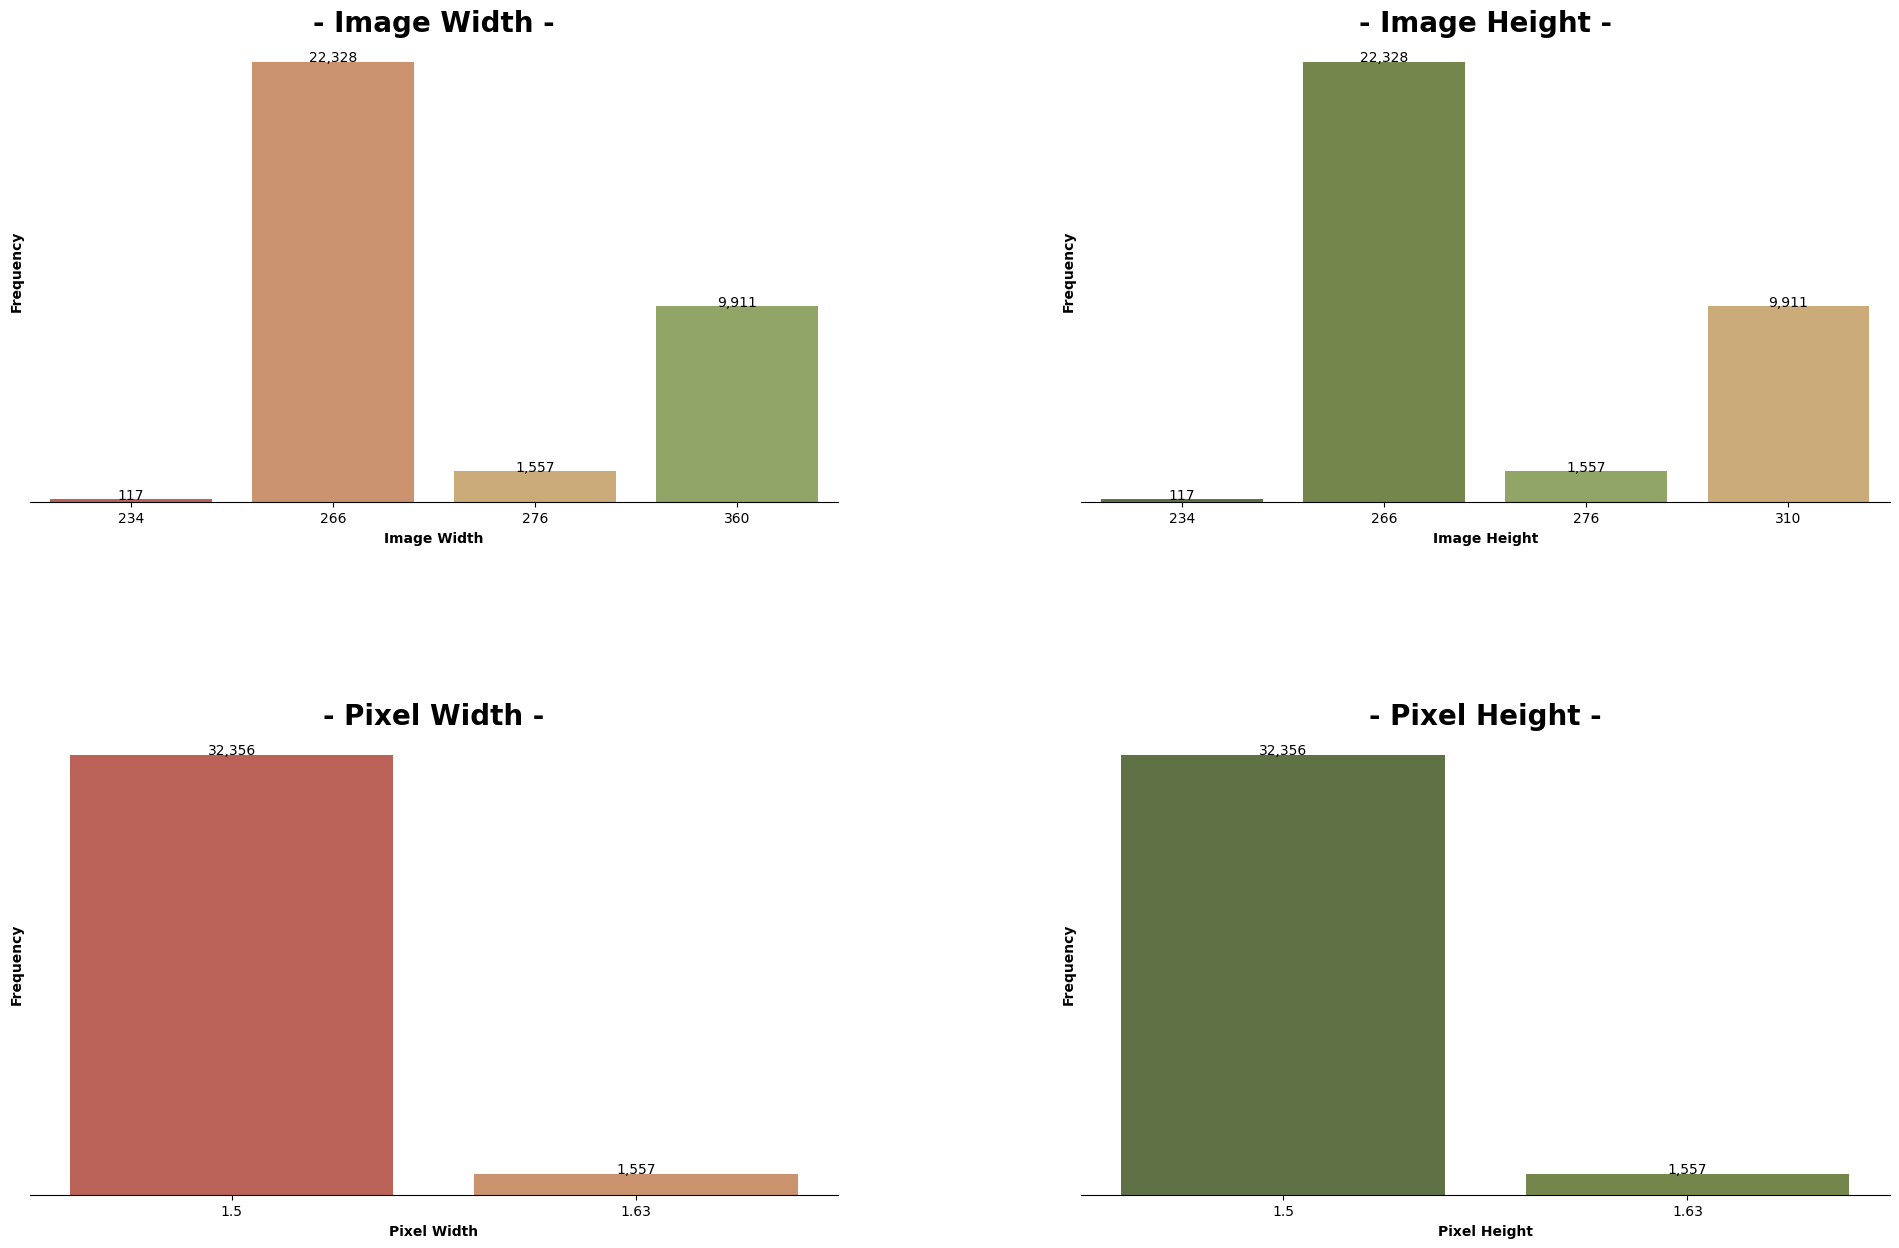

In [21]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(24,15))
titles = ['Image Width', 'Image Height', 'Pixel Width', 'Pixel Height']
data = train[train['image_width'] != 0].reset_index(drop=True)

sns.barplot(y=data['image_width'].value_counts(), x=data['image_width'].value_counts().index, ax=ax1, palette=my_colors )

sns.barplot(y=data['image_height'].value_counts(), x=data['image_height'].value_counts().index, ax=ax2, palette=my_colors[::-1] )

sns.barplot(y=data['pixel_width'].value_counts(), x=data['pixel_width'].value_counts().index, ax=ax3, palette=my_colors )

sns.barplot(y=data['pixel_height'].value_counts(), x=data['pixel_height'].value_counts().index, ax=ax4, palette=my_colors[::-1] )


for ax, t in zip([ax1, ax2, ax3, ax4], titles):
    show_values_on_bars(ax, h_v="v", space=0.4)
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_ylabel("Frequency", weight="bold")
    ax.set_xlabel(f"{t}", weight="bold")
    ax.get_yaxis().set_ticks([]);
    
sns.despine(left=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5);

Images are square shaped

In [54]:
dt = train["image_width"].value_counts().reset_index()

create_wandb_plot(y_data=dt['count'],
                  x_data=dt["image_width"], 
                  y_name="Frequency", 
                  x_name="Image Width/Height", 
                  title="Image Width x Height",
                  log="img_specs", plot="bar")

dt = train["pixel_width"].value_counts().reset_index()

create_wandb_plot(y_data=dt['count'],
                  x_data=dt["pixel_width"], 
                  y_name="Frequency", 
                  x_name="Pixel Width/Height", 
                  title="Pixel Width x Height",
                  log="pixel_specs", plot="bar")

**Segementation View**

In [47]:
a = train.groupby('id')['segmentation'].count().reset_index()['segmentation'].value_counts().reset_index()
a

segmentation  count
0             0  21906
1             2  10921
2             3   3201
3             1   2468

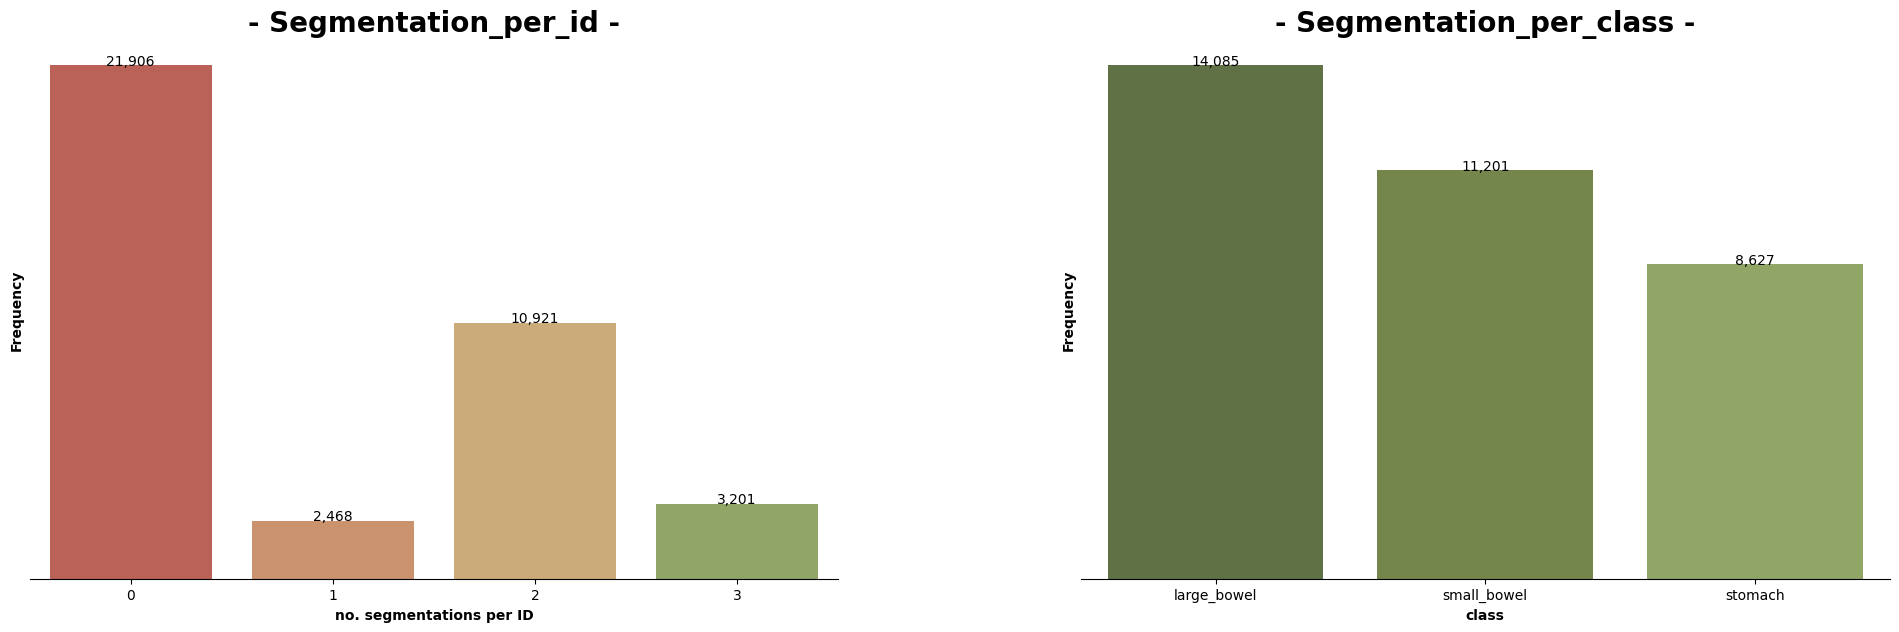

In [51]:
segment_per_id = train.groupby('id')['segmentation'].count().reset_index()['segmentation'].value_counts().reset_index()
segment_per_class = train.groupby('class')['segmentation'].count().reset_index()
titles = ['Segmentation_per_id', 'Segmentation_per_class']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,7))

sns.barplot(y=segment_per_id['count'], x=segment_per_id['segmentation'], ax=ax1, palette=my_colors)
sns.barplot(x=segment_per_class['class'], y=segment_per_class['segmentation'], ax=ax2, palette=my_colors[::-1])

for ax, t, x in zip([ax1, ax2], titles, ["no. segmentations per ID", "class"]):
    show_values_on_bars(ax, h_v="v", space=0.4)
    ax.set_title(f"- {t} -", size=20, weight="bold")
    ax.set_ylabel("Frequency", weight="bold")
    ax.set_xlabel(f"{x}", weight="bold")
    ax.get_yaxis().set_ticks([]);
    
sns.despine(left=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.5);

In [55]:
create_wandb_plot(y_data=segment_per_id["count"],
                  x_data=segment_per_id["segmentation"], 
                  x_name="Segmentations per ID", 
                  y_name="Frequency", 
                  title=f"{titles[0]}",
                  log="segm_id", plot="bar")

create_wandb_plot(x_data=segment_per_class["class"],
                  y_data=segment_per_class["segmentation"], 
                  x_name="Class", 
                  y_name="Frequency", 
                  title=f"{titles[1]}",
                  log="segm_class", plot="bar")

In [56]:
wandb.finish()

**Explore Images**

In [13]:
run = wandb.init(project='AWMadison', name='make_masks', config=CONFIG)

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


It's important to analyse the dataset because we will need to normalize the data to convert it into a format that is more expected for machine learning (uint8 (0-255) or float32 (0-1)). Without knowing the limits of the images, we may diminish the resolution of the data by accident when normalizing.


OBSERVATIONS

Interestingly the maximum value in the dataset is equiavlent to less than half of an int16 or a quarter of a uint16.

Max Value for UINT16
65535
Max Value for INT16
32767
Half of Max Value for INT16
16384
Actual Max Value in the dataset
15865

In [14]:
def read_image(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype('float32')
    image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    image = image.astype(np.u int8)
    
    return image

In [15]:
def show_simple_images(sample_paths, image_names="sample_images"):
    # Get additional info from the path
    case_name = [info.split("_")[0][-7:] for info in sample_paths]
    day_name = [info.split("_")[1].split("/")[0] for info in sample_paths]
    slice_name = [info.split("_")[2] for info in sample_paths]


    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 8))
    axs = axs.flatten()
    wandb_images = []

    for k, path in enumerate(sample_paths):
        title = f"{k+1}. {case_name[k]} - {day_name[k]} - {slice_name[k]}"
        axs[k].set_title(title, fontsize = 14, 
                         color = my_colors[-1], weight='bold')

        img = read_image(path)
        wandb_images.append(wandb.Image(img))
        axs[k].imshow(img)
        axs[k].axis("off")

    plt.tight_layout()
    plt.show()

    # 🐝 Log Image to W&B
    wandb.log({f"{image_names}": wandb_images})

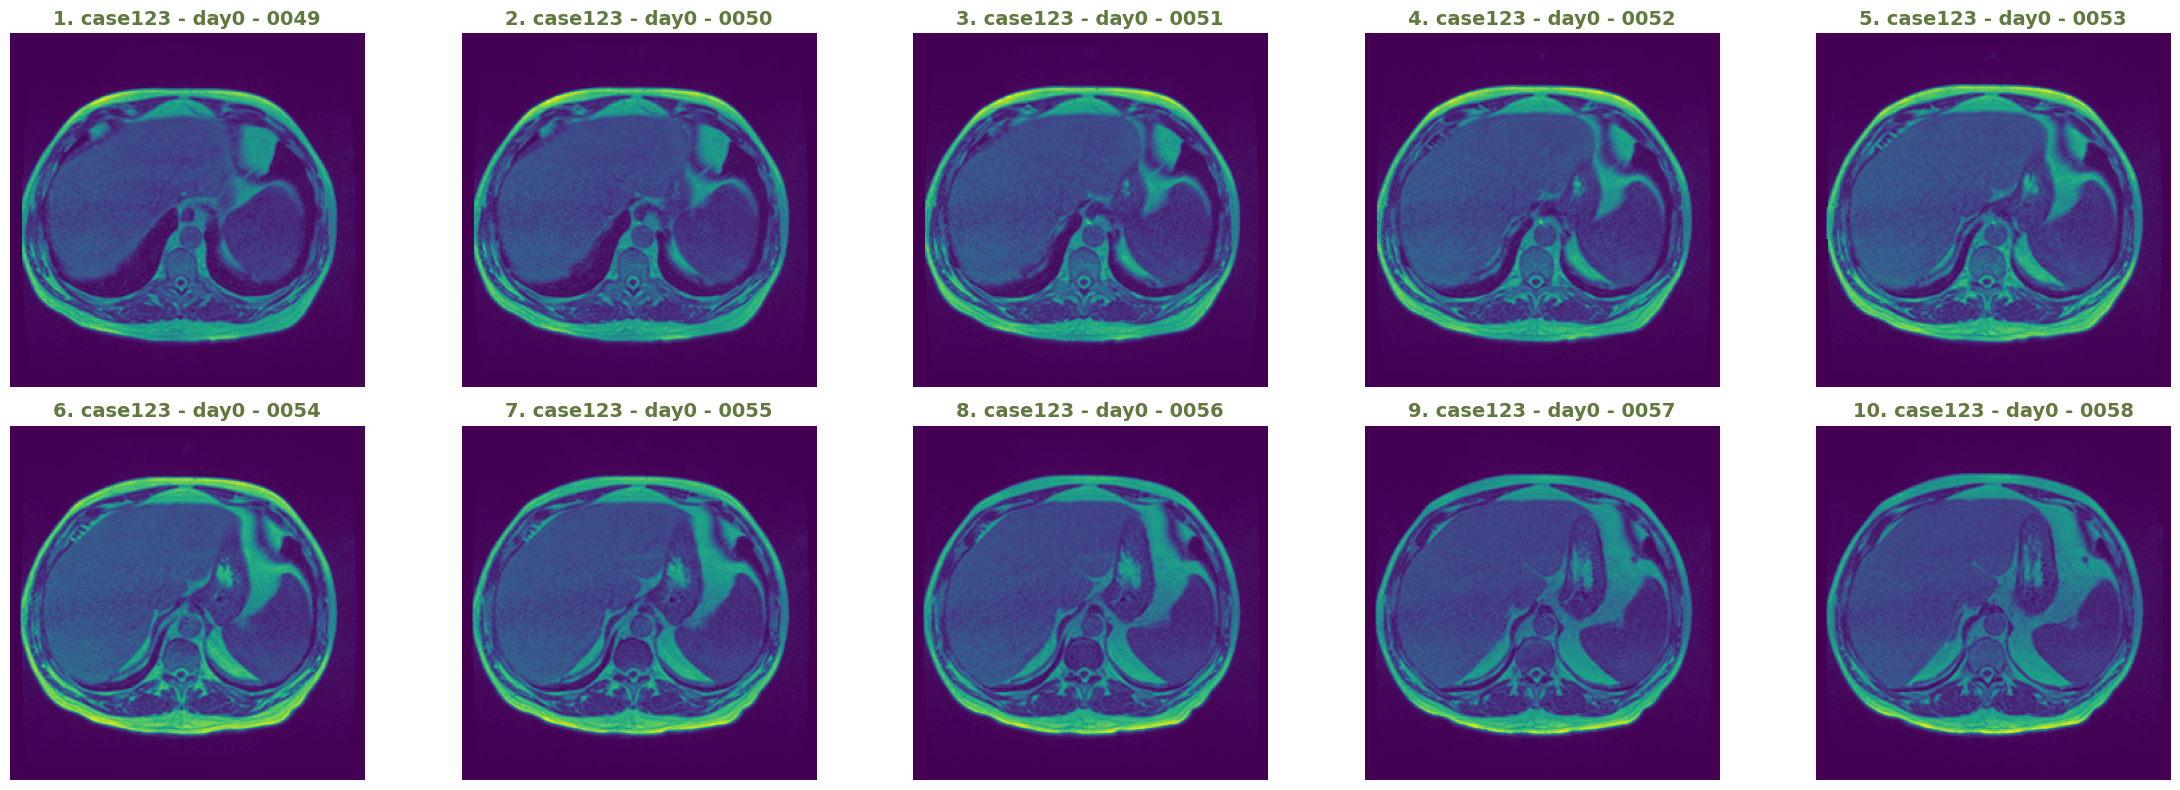

In [16]:
CASE = "case123"

sample_paths1 = train[(train["segmentation"].isna()==False) & (train["case"]==CASE)]["path"].reset_index()\
                .groupby("path")["index"].count()\
                .reset_index().loc[:9, "path"].tolist()

show_simple_images(sample_paths1, image_names="case123_samples")

**Run Length decoding to obtain masks**

In [83]:
type(train.iloc[194,2])

str

In [105]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
# modified from: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle,shape, color=1):
    split = np.array(mask_rle.split(), dtype =int)

    starts = split[0::2] - 1
    lengths = split[1::2]
    ends = starts + lengths
    
    height, width = shape
    mask = np.zeros(height*width, dtype=np.uint8)
    
    for low, high in zip(starts, ends):
        mask[low:high] = color
   
    return mask.reshape((height,width))

In [106]:
# print images and masks

def explore_masks(id, df = train, plot_overlay = False, plot_binary_segmentation = False):
    print('RLE Encoding for case_day_sliceid:', id)
    if plot_binary_segmentation:
        data = df[(df['id'] == id) & (df['segmentation'].isna() == False)]
        seg_types = data['class'].tolist()
        for i, each in enumerate(seg_types):
            print(each)
            mask_rle = data[data['class'] == each]['segmentation'].tolist()
            width = data[data['class'] == each]['image_width']
            height = data[data['class'] == each]['image_height']
            width = width.values[0]
            height = height.values[0]
            
            plt.subplot(1,3,i+1)
            plt.imshow(rle_decode(mask_rle[0], shape=(height, width), color=1))
            plt.title(f"{each}", fontweight="bold")
            plt.axis(False)
            
        plt.tight_layout()
        plt.show()

RLE Encoding for case_day_sliceid: case123_day20_slice_0082
large_bowel
small_bowel
stomach


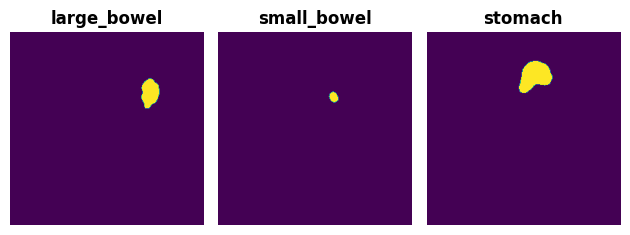

In [107]:
explore_masks('case123_day20_slice_0082', plot_binary_segmentation = True)

In [109]:
train.head()

id        class segmentation     case    day  \
0  case123_day20_slice_0001  large_bowel          NaN  case123  day20   
1  case123_day20_slice_0001  small_bowel          NaN  case123  day20   
2  case123_day20_slice_0001      stomach          NaN  case123  day20   
3  case123_day20_slice_0002  large_bowel          NaN  case123  day20   
4  case123_day20_slice_0002  small_bowel          NaN  case123  day20   

  slice_no path  image_width  image_height  pixel_width  pixel_height  
0     0001    0            0             0          0.0           0.0  
1     0001    0            0             0          0.0           0.0  
2     0001    0            0             0          0.0           0.0  
3     0002    0            0             0          0.0           0.0  
4     0002    0            0             0          0.0           0.0

In [117]:
def get_masks_by_ID(caseID, df = train):
    df_id = df[df["id"] == caseID].reset_index()
    
    observations = [df_id.loc[k, :] for k in range(3)]
    max_height = np.max([obs.image_height for obs in observations])
    max_width = np.max([obs.image_width for obs in observations])
    
    shape = (max_height, max_width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    
    if max_height:
        for k, location in enumerate(["large_bowel", "small_bowel", "stomach"]):
            observation = observations[k]
            segmentation = observation.segmentation
            if pd.isnull(segmentation) == False:
                # mask_rle = data[data['class'] == each]['segmentation'].tolist()
                mask_shape = (max_height, max_width)
                mask[..., k] = rle_decode(segmentation, mask_shape, color=1)
            elif max_height == 0:
                mask = None
    return mask

In [118]:
ID = "case131_day0_slice_0066"
mask = get_masks_by_ID(ID)

In [108]:
def plot_mask_on_original(original, mask, alpha = 1):
    mask = np.ma.masked_where(mask == 0, mask)
    
    mask_large_bowel = mask[:,:,0] 
    mask_small_bowel = mask[:,:,1]
    mask_stomach = mask[:,:,2]
    
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(24,10))
    
    ax1.set_title("Original Image")
    ax1.imshow(original)
    ax1.axis("off")
    
    ax2.set_title("Image with Mask")
    ax2.imshow(original)
    ax2.imshow(mask_large_bowel, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_small_bowel, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
    plt.show()

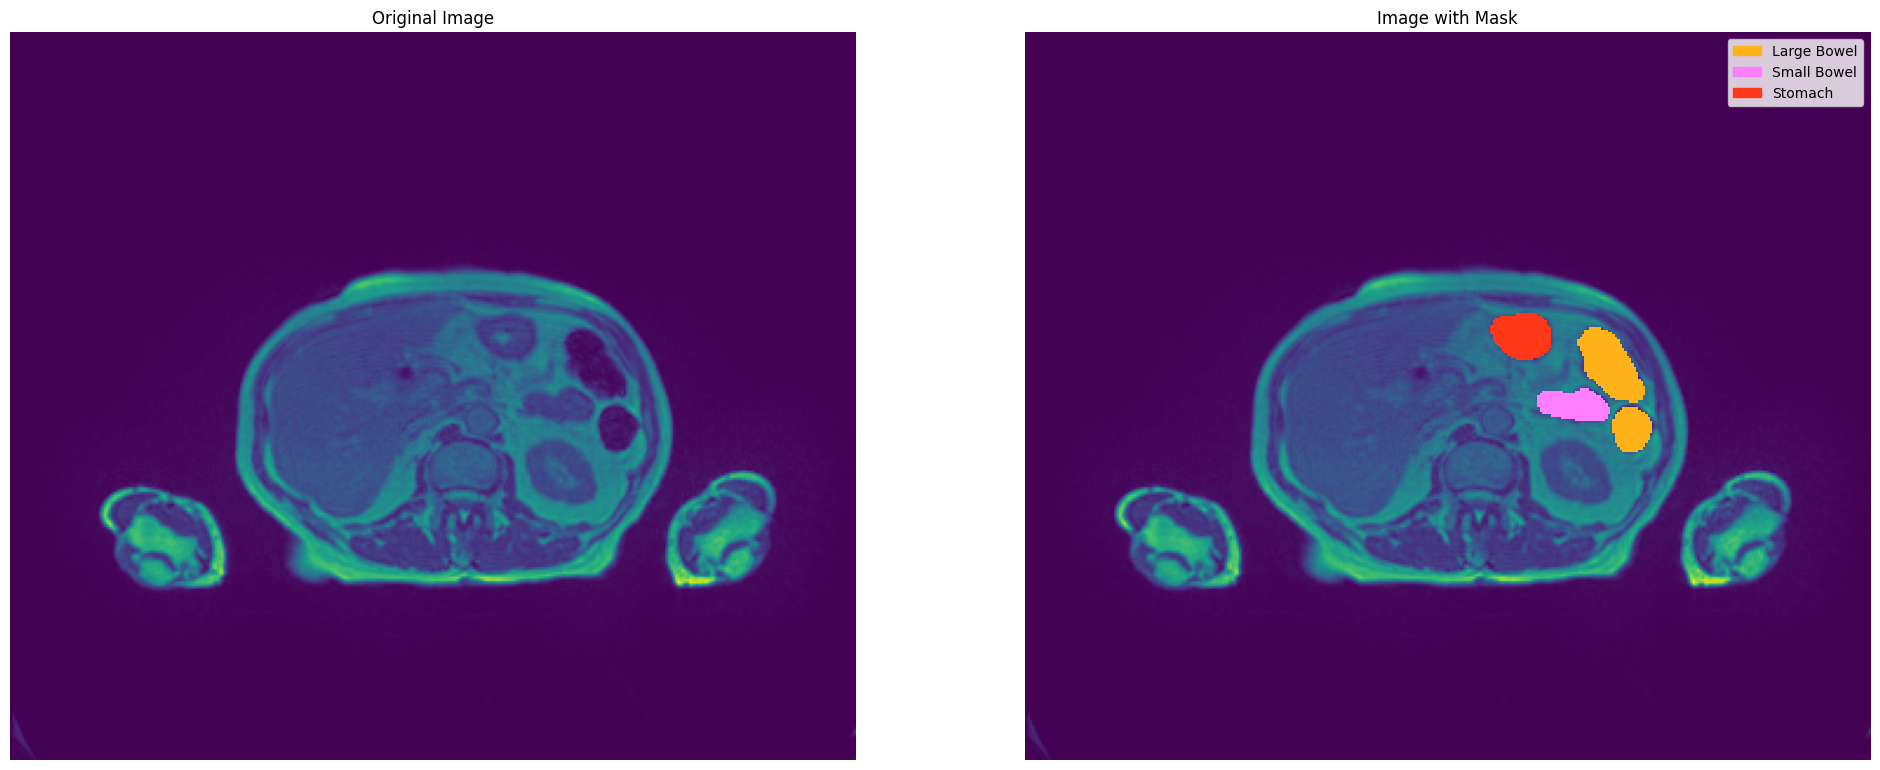

In [119]:
path = '/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case131/case131_day0/scans/slice_0066_360_310_1.50_1.50.png'
img = read_image(path)
plot_mask_on_original(img, mask)

**Explore Masks**

In [121]:
data = train[train["segmentation"].isna()==False].reset_index(drop=True)
data.head()

id    class  \
0  case123_day20_slice_0065  stomach   
1  case123_day20_slice_0066  stomach   
2  case123_day20_slice_0067  stomach   
3  case123_day20_slice_0068  stomach   
4  case123_day20_slice_0069  stomach   

                                        segmentation     case    day slice_no  \
0  28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...  case123  day20     0065   
1  27561 8 27825 11 28090 13 28355 14 28620 15 28...  case123  day20     0066   
2  15323 4 15587 8 15852 10 16117 11 16383 12 166...  case123  day20     0067   
3  14792 5 15056 9 15321 11 15587 11 15852 13 161...  case123  day20     0068   
4  14526 6 14789 12 15054 14 15319 16 15584 17 15...  case123  day20     0069   

                                                path  image_width  \
0  /kaggle/input/uw-madison-gi-tract-image-segmen...          266   
1  /kaggle/input/uw-madison-gi-tract-image-segmen...          266   
2  /kaggle/input/uw-madison-gi-tract-image-segmen...          266   
3  /kaggle/input/uw-madison-gi-tract-image-segmen...          266   
4  /kaggle/input/uw-madison-gi-tract-image-segmen...          266   

   image_height  pixel_width  pixel_height  
0           266          1.5           1.5  
1           266          1.5           1.5  
2           266          1.5           1.5  
3           266          1.5           1.5  
4           266          1.5           1.5

In [124]:
def plot_masks_chronologic(imgs, masks, ids, alpha=1):
    
    slices = [i.split("_")[-1] for i in ids]
    
    # Plot
    fig, axs = plt.subplots(2, 5, figsize=(23, 11))
    axs = axs.flatten()
    
    for k, (img, mask) in enumerate(zip(imgs, masks)):

        # Change pixels - when 1 make True, when 0 make NA
        mask = np.ma.masked_where(mask == 0, mask)

        # Split the channels
        mask_largeB = mask[:, :, 0]
        mask_smallB = mask[:, :, 1]
        mask_stomach = mask[:, :, 2]
        
        title = f"{k+1}. Slice {slices[k]}"
        axs[k].set_title(title, fontsize = 16, 
                         color = my_colors[-1], weight='bold')

        axs[k].imshow(img, cmap="gist_gray")
        axs[k].axis("off")
        axs[k].imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
        axs[k].imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
        axs[k].imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
        axs[k].axis("off")
        
        axs[0].legend(legend_colors, labels, loc=2)
    plt.tight_layout()
    plt.show()

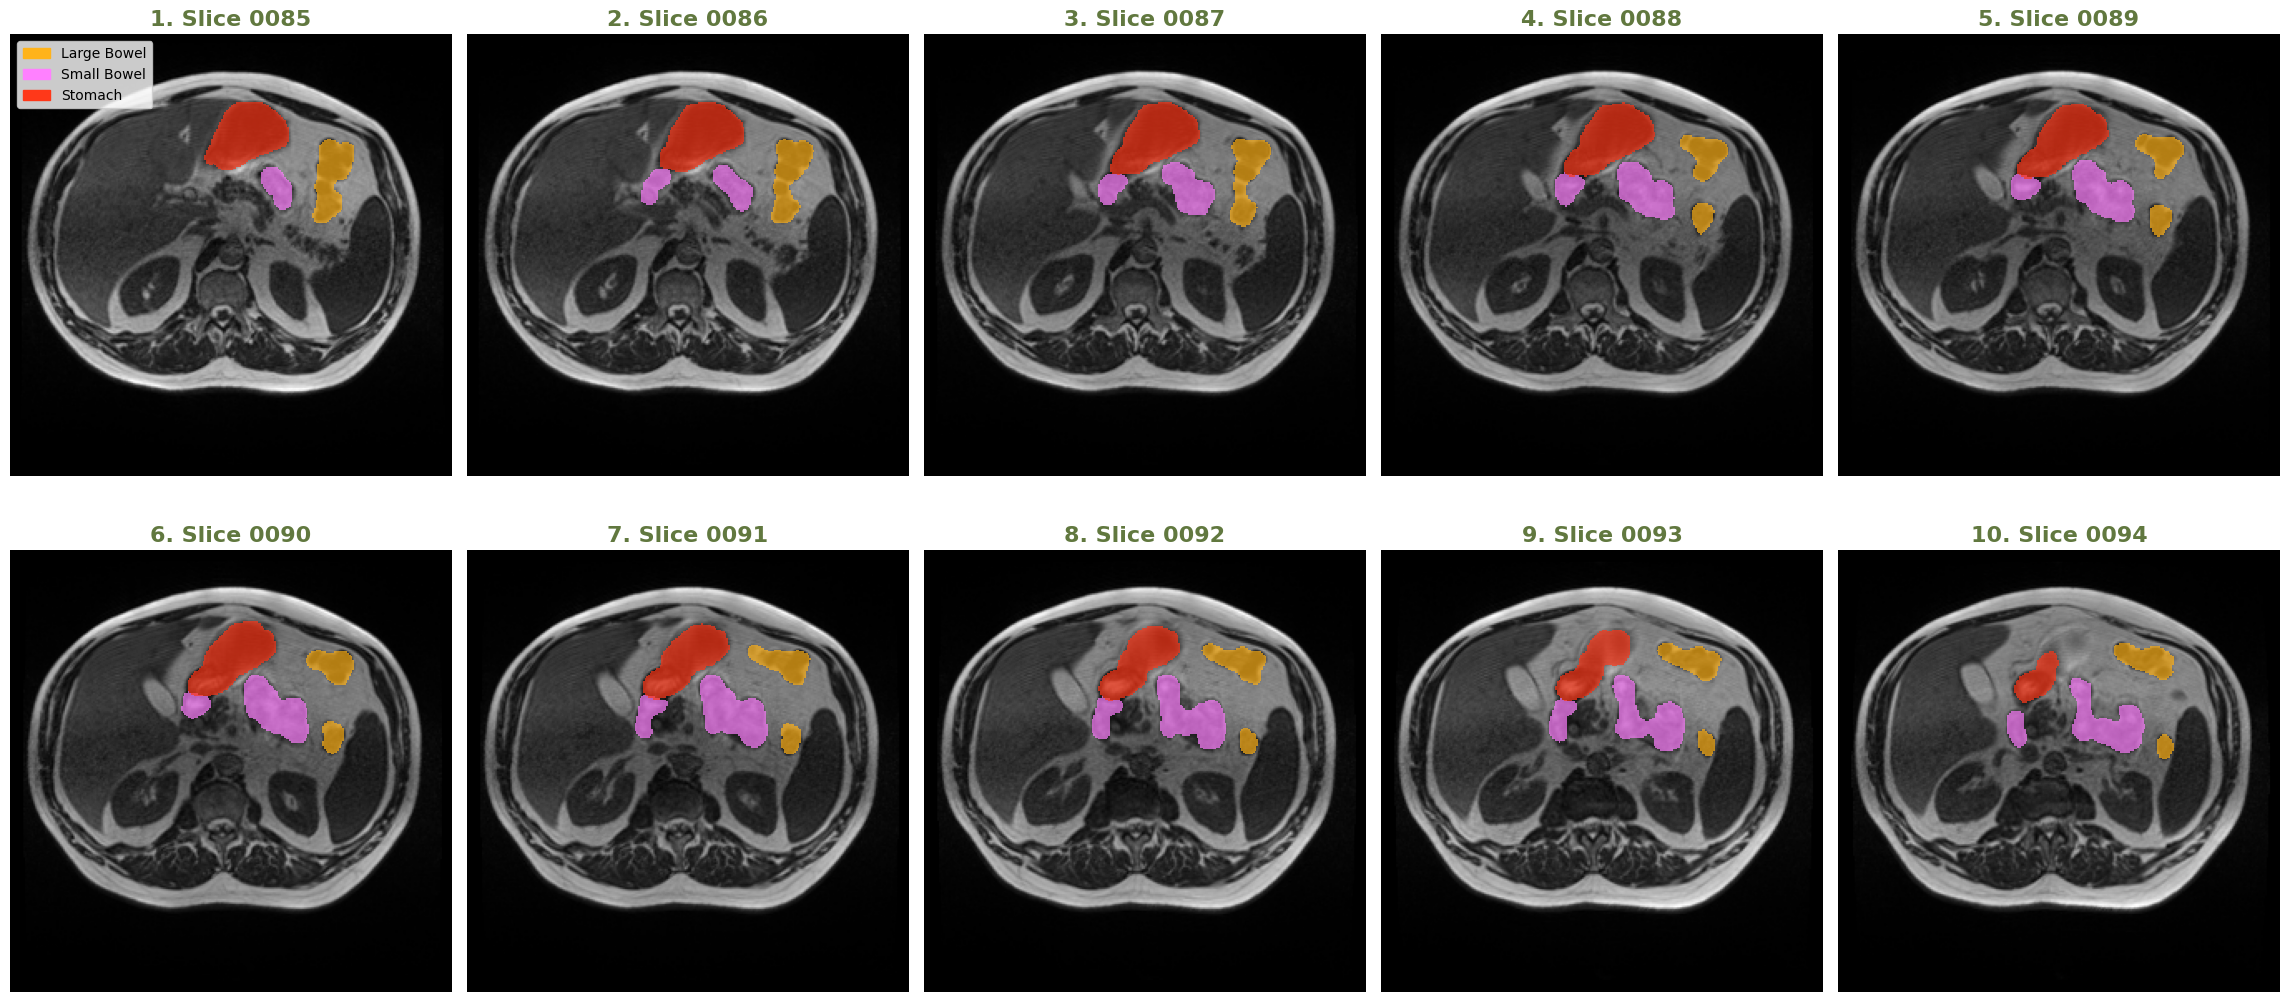

In [125]:
case = "case123"
day="day20"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_masks_by_ID(i) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

wandb.log({f"{image_names}": wandb_images})

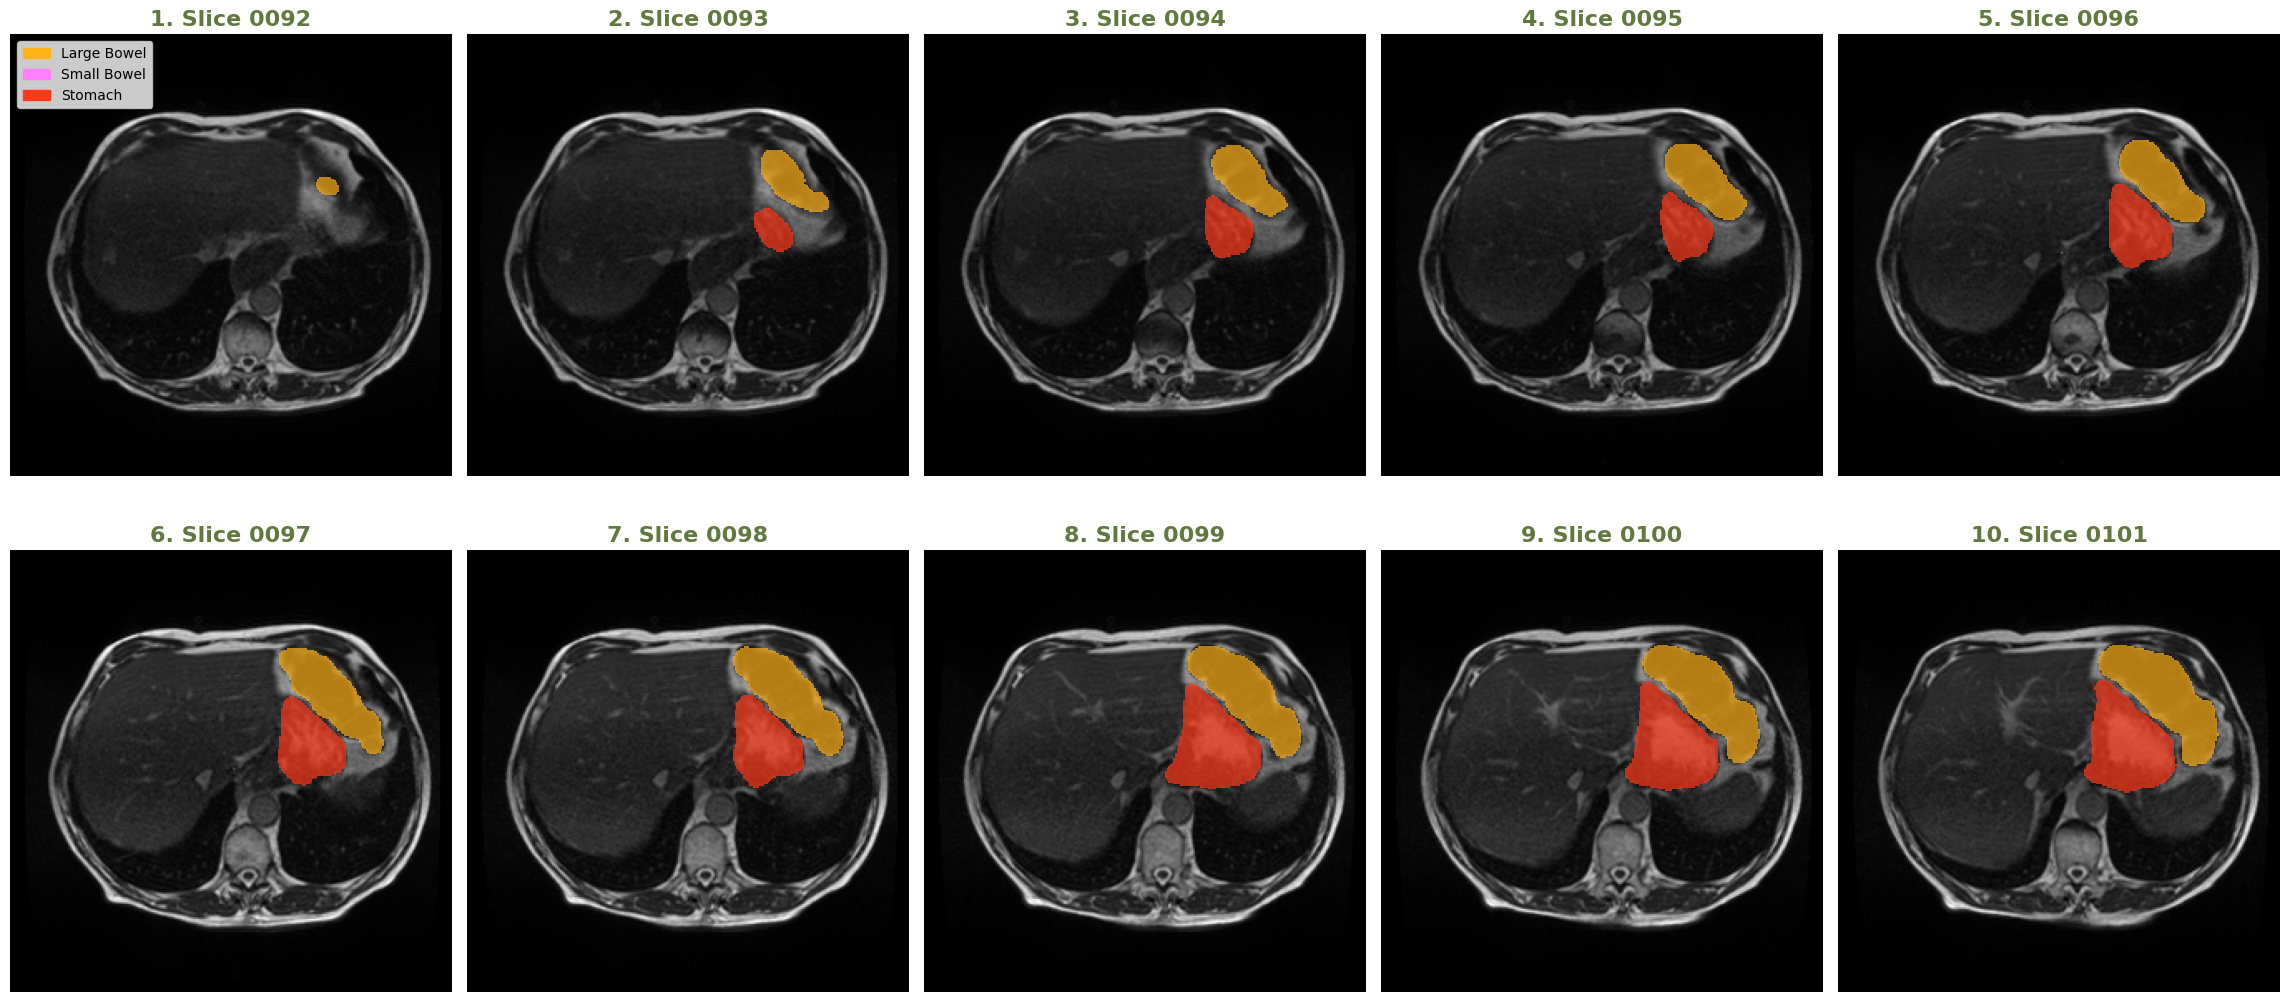

In [127]:
case = "case30"
day="day0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().head(10)

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_masks_by_ID(i) for i in df["id"].tolist()]
plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

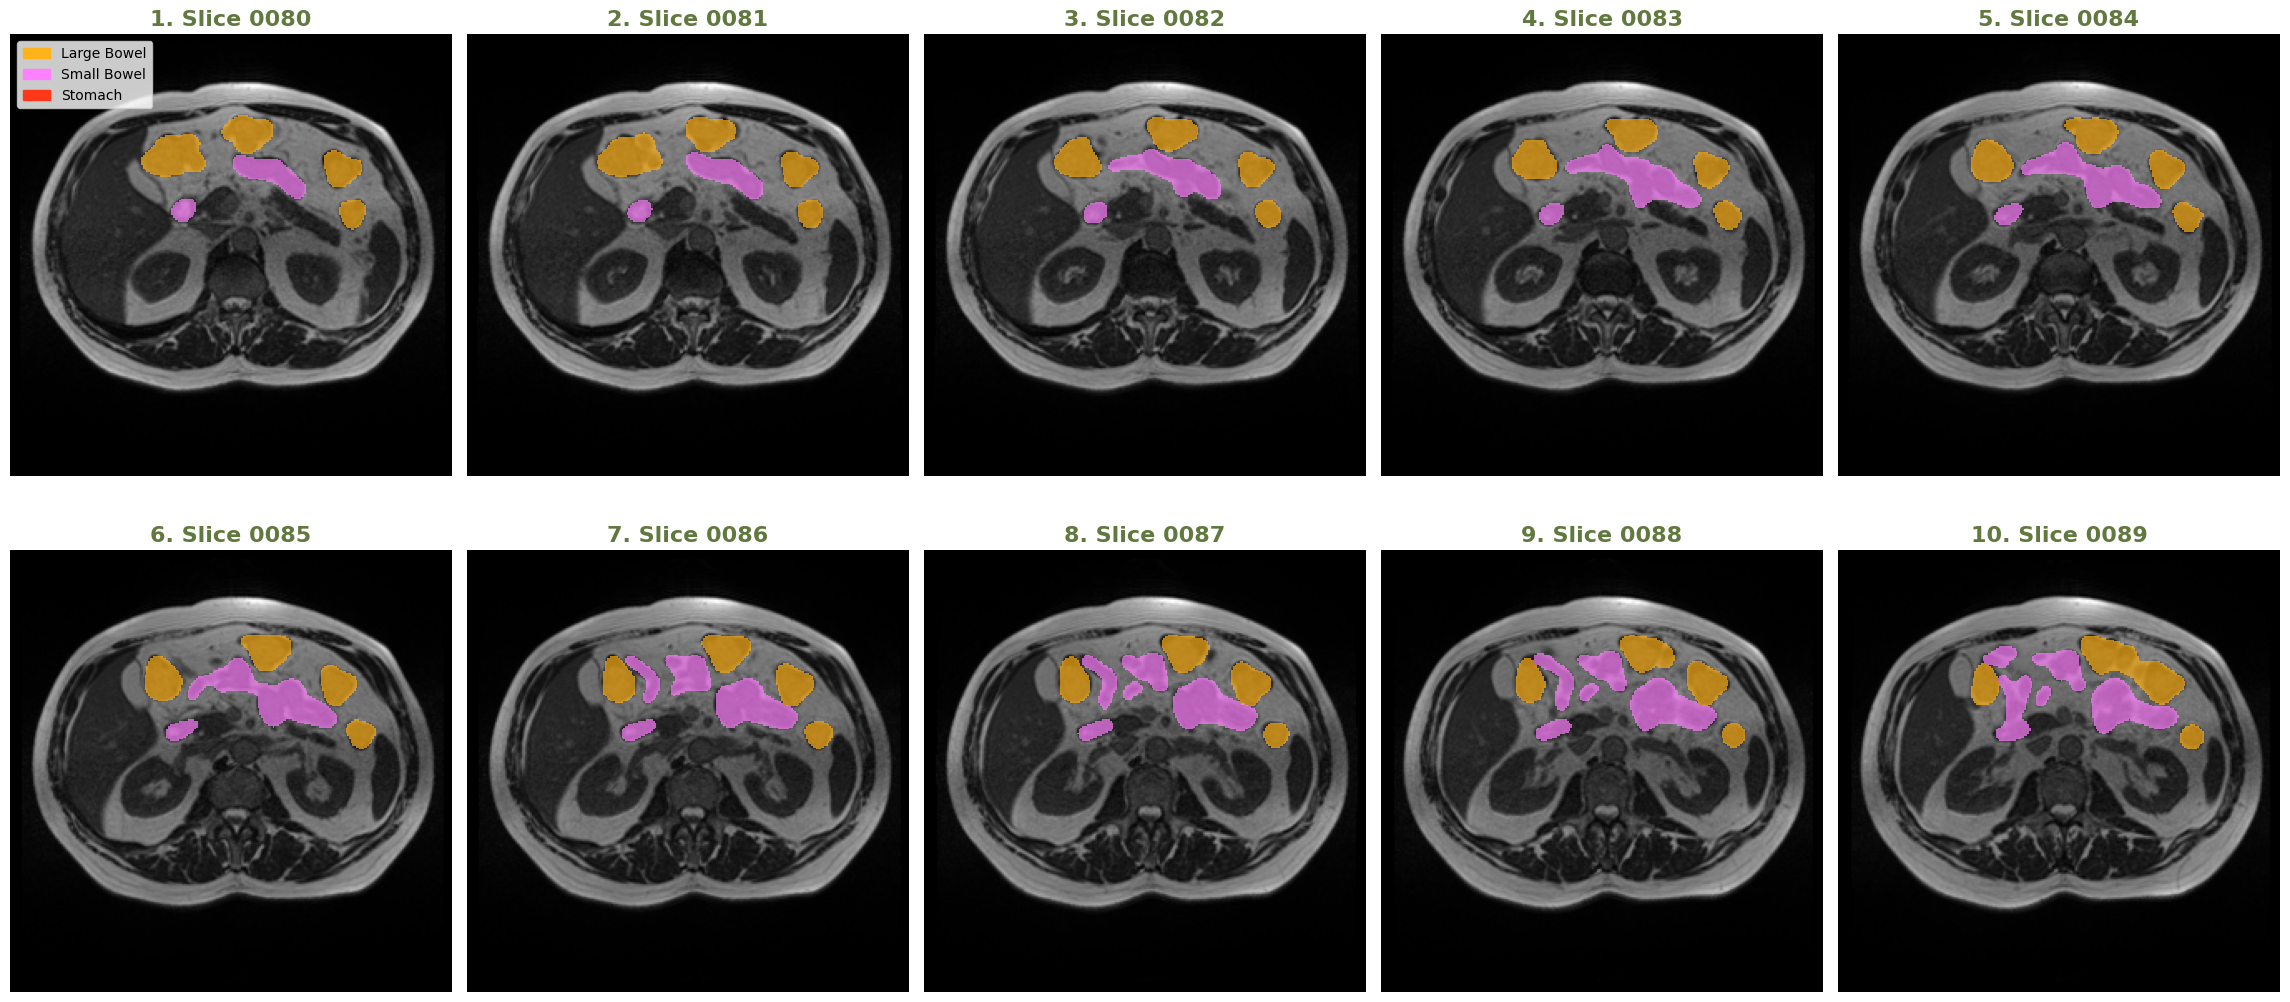

In [128]:
case = "case146"
day="day0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[20:29, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_masks_by_ID(i) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

to show overlap

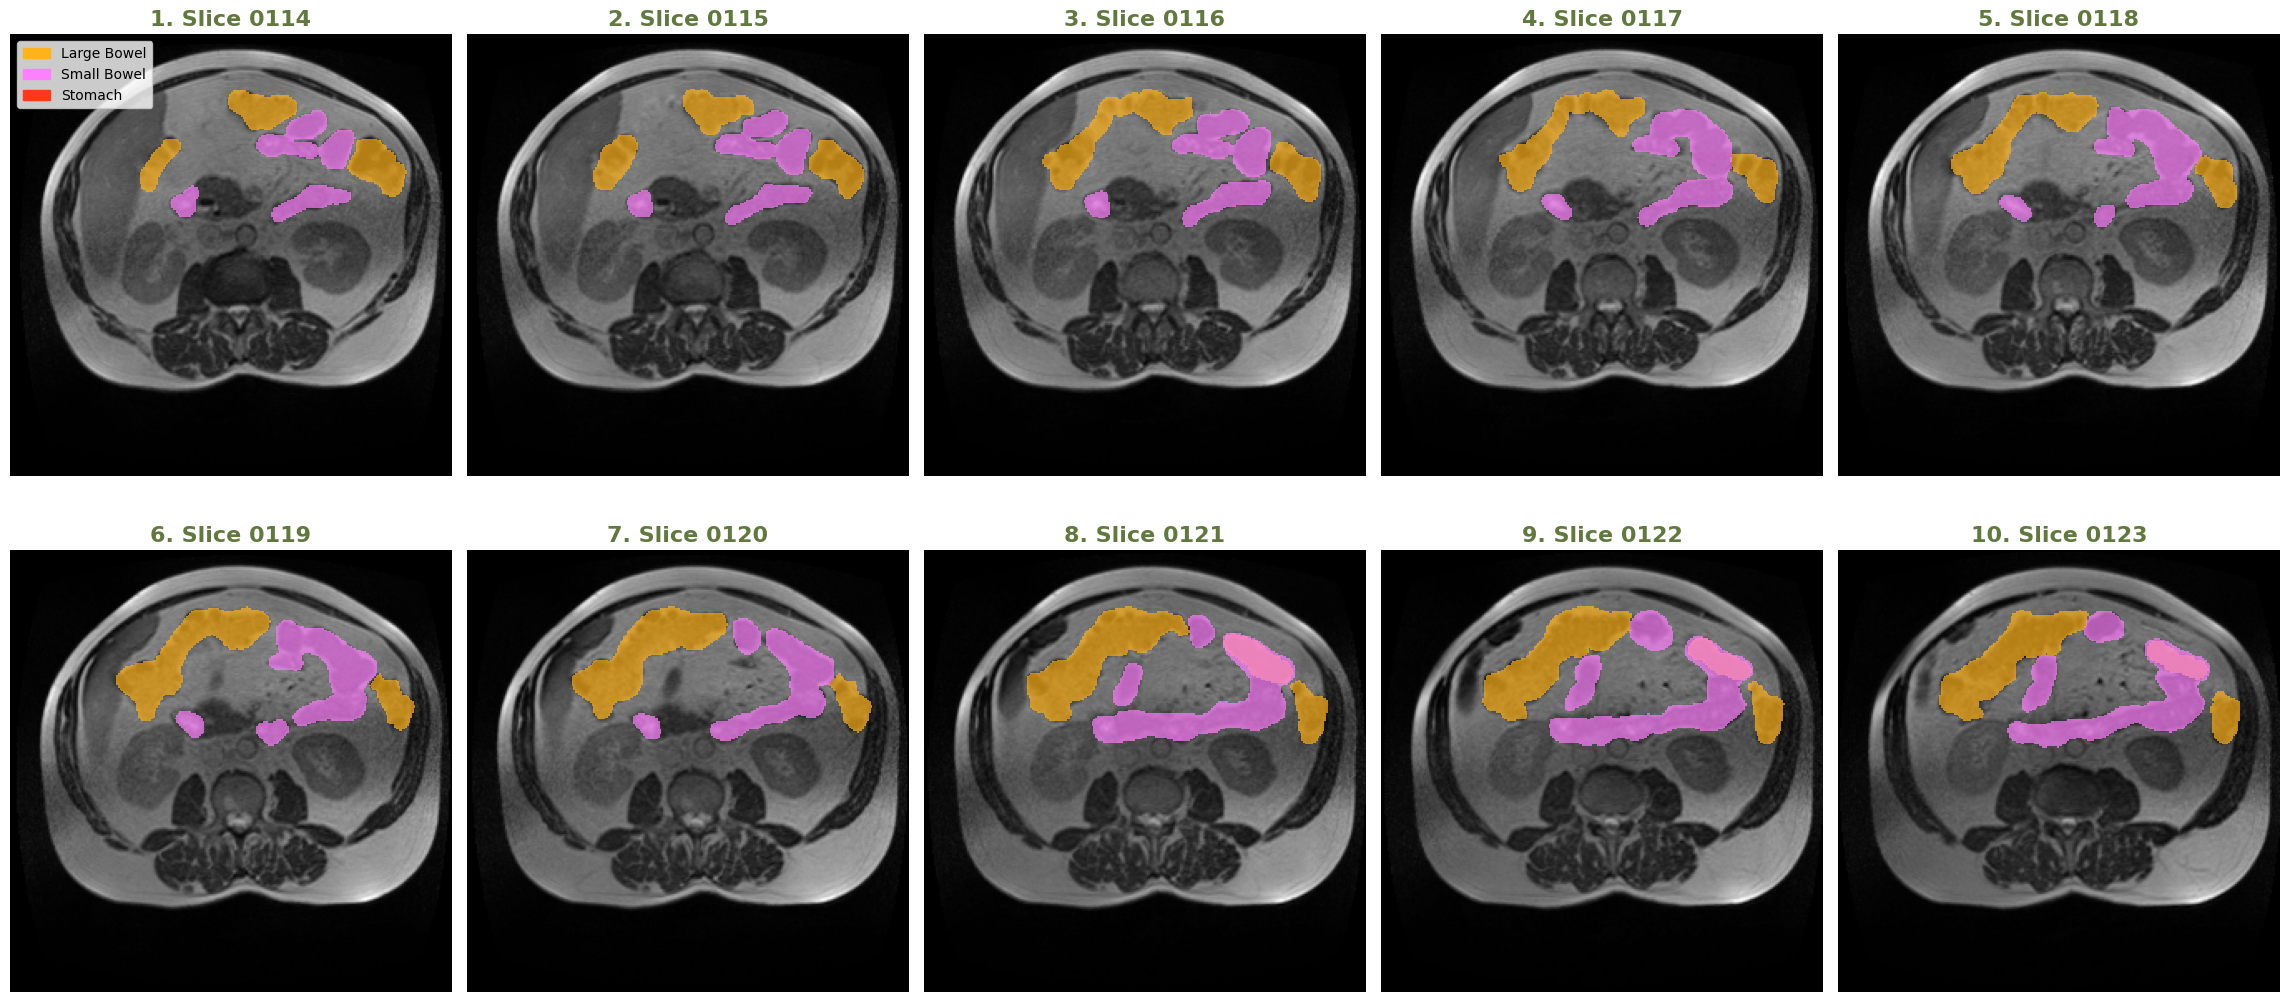

In [135]:
case = "case84"
day="day0"

# Get ids and paths for that case
# drop duplicates (for when 2 or more segments are present)
df = data[(data["case"]==case) & (data["day"]==day)].drop_duplicates("path")\
                            .reset_index().loc[36:45, :]

IMGS = [read_image(path) for path in df["path"].to_list()]
MASKS = [get_masks_by_ID(i) for i in df["id"].tolist()]

plot_masks_chronologic(IMGS, MASKS, ids=df["id"].tolist(), alpha=0.7)

In [129]:
wandb.finish()